# PGVnet: Predicting Peak Ground Velocity (PGV) Maps

**Purpose.** Demonstrate a two-step framework to predict spatially-continuous PGV maps:
1) Train receiver-specific XGBoost predictors to generate a sparsely-sampled PGV.
2) Train an encoder–MLP network to finetune PGV maps from sparse inputs.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pgvnet import train_xgb, generate_sparse_pgv, run_train
from pgvnet.encoderMLP_predictor import run_test
import os, yaml 
from types import SimpleNamespace

## Step 1 — Train Receiver-Specific XGBoost Models

We demonstrate training for **one receiver** (receiver 139 as an example).  
Models for the remaining receivers are available via [Zenodo](#) and are stored in `xgb_models/`.

Training R²: 0.9302
Test R²: 0.8886


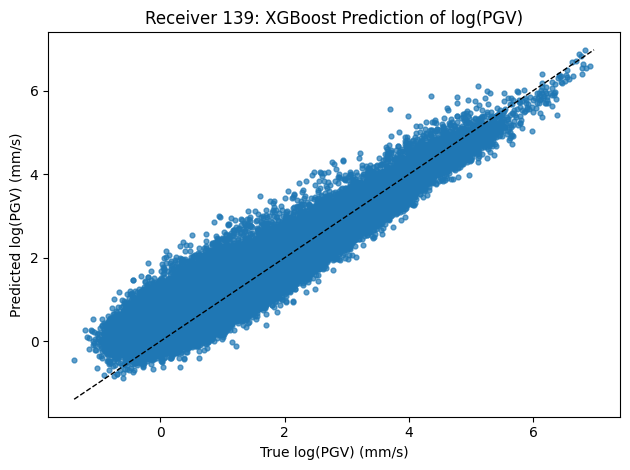

In [2]:
# Pick one receiver for demonstration (0–255 typical)
receiver_idx = 139
db_path      = f"data/reciprocal_db/receiver_{receiver_idx}_database.npz"
assert os.path.exists(db_path), f"Missing: {db_path}"

# Load receiver database
rec_db = np.load(db_path)
X = rec_db["inputs"]            # [distance, azimuth, depth, strike, dip, rake, radiation, takeoff]
y = np.log(rec_db["outputs"][:, 0])  # log(PGV) for East–West component

# Train XGBoost model
y_true, y_pred = train_xgb(X, y)

# Scatter plot: True vs. Predicted log(PGV)
fig, ax = plt.subplots()
ax.scatter(y_true, y_pred, s=12, alpha=0.7)
low, high = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
ax.plot([low, high], [low, high], linestyle="--", linewidth=1, color="k")
ax.set_xlabel("True log(PGV) (mm/s)")
ax.set_ylabel("Predicted log(PGV) (mm/s)")
ax.set_title(f"Receiver {receiver_idx}: XGBoost Prediction of log(PGV)")
plt.tight_layout()
plt.show()


Once the per-receiver XGBoost models are trained, we generate **sparse PGV maps** for a set of sources and source mechanisms.  

These sparse maps are then used as inputs to the **encoder–MLP network** in Step 2.


In [ ]:
# Example tags/paths (adjust to your setup)
data_tag   = "10_50"
models_dir = "data/xgb_models"
spacing_km = 4
station_coords_path = "data/receiver_coords_sparse.npz"
output_path         = "data/step1_preds"

# Generate sparse PGV maps
sparse_maps = generate_sparse_pgv(station_coords_path, models_dir, output_path, data_tag, spacing_km)

# Visualize one sparse map at station locations (EW component = [:,:,0])
coords = np.load(station_coords_path)["station_coords"]
fig, ax = plt.subplots()
sc = ax.scatter(coords[:, 0] / 1e3, coords[:, 1] / 1e3, c=sparse_maps[0, :, :, 0], s=70, cmap="plasma")
ax.set_xlabel("East Distance (km)")
ax.set_ylabel("North Distance (km)")
ax.set_title("Sparse PGV at Station Locations (EW)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("PGV (mm/s)")
plt.tight_layout()
plt.show()

## Step 2 — Train Encoder–MLP on Sparse PGV maps

Next, we train an **encoder–MLP network** to refine the PGV maps.  

The configuration below is explicit and minimal; you may tune hyperparameters, architecture, or training strategy as required for your dataset.

In [ ]:
from dataclasses import dataclass

# Configuration for training the encoder-MLP network
@dataclass
class Config:
    mode: str = "train"
    data_tag: str = "10_50_x4"
    downsample_factor: int = 4
    data_dir: str = "data/"
    transform_input: bool = True
    transform_output: bool = True
    inc_gradient: bool = False
    inc_distance: bool = True
    normalize_output: bool = True
    normalize_input: bool = True
    nx_patch: int = 8
    ny_patch: int = 8
    fourier_features: bool = False
    D: int = 32
    gamma: float = 5.0
    n_samp_pts_per_patch: int = 512
    split: float = 0.8
    batch_size: int = 32
    learning_rate: float = 1e-3
    loss_type: str = "mse"
    optimizer: str = "adamw"
    num_epochs: int = 1
    enc_type: str = "edsr"
    in_channels: int = 5
    out_channels: int = 32
    conv_kernel_size: int = 3
    attention_kernel_size: int = 1
    num_features: int = 32
    num_blocks: int = 8
    nf: int = 32
    activation: str = "leaky_relu"
    pad_size: int = 4
    sigma: float = 3.0
    results_dir: str = None
    stats_tag: str = "10_50_x4"

# Initialize config
config = Config()

# Run training
run_train(config)

## Evaluation on Held-Out Events

The evaluation procedure is designed to assess the framework’s performance on a held-out subset of events.  
Each training run produces a corresponding configuration file (e.g., `results/example_run/config.yaml`), which fully specifies the model setup and data parameters used during training.

The provided `example_run` configuration corresponds to the **large-scale `100_50_x4` dataset**, available on [Zenodo](#).  
For demonstration purposes, a **smaller dataset** is included directly in this repository, enabling users to reproduce the complete workflow on a reduced example.

To perform evaluation, use the configuration file generated from your own training run and modify the following fields:

- `mode = "test"`  
- `results_dir = "<your_results_dir>"`

Executing the evaluation applies the trained model to the held-out subset and generates the following outputs:

- `test_preds.npy` — predicted dense PGV maps  
- `test_gts.npy` — corresponding ground-truth maps  

All outputs are written to the specified results directory.  
These files can subsequently be used for quantitative evaluation (e.g., RMSE, correlation analysis) or for visualization of the reconstructed PGV fields.



In [ ]:
cfg_path = "results/example_run/config.yaml"
assert os.path.exists(cfg_path), f"Config not found: {cfg_path}"

with open(cfg_path, "r") as f:
    cfg_dict = yaml.safe_load(f)

config = SimpleNamespace(**cfg_dict)
config.mode = "test"
config.results_dir = "results/example_run"

# Run evaluation
run_test(config)

We compare predicted vs. true PGV maps on the test split

In [ ]:
preds = np.load("results/example_run/test_preds.npy")
gts   = np.load("results/example_run/test_gts.npy")

idx  = np.random.randint(0, preds.shape[0])   # random test example
comp = 1  # 0: East–West, 1: North–South

pred = preds[idx, :, :, comp] / 10.0  # cm/s
gt   = gts[idx, :, :, comp] / 10.0    # cm/s

vmax = max(np.max(gt), np.max(pred))
norm = plt.Normalize(vmin=0, vmax=vmax)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)
cf0 = axes[0].contourf(gt, cmap="plasma", norm=norm)
cf1 = axes[1].contourf(pred, cmap="plasma", norm=norm)

axes[0].set_title("True PGV (cm/s)")
axes[1].set_title("Predicted PGV (cm/s)")
for ax in axes:
    ax.set_xlabel("East Distance (km)")
axes[0].set_ylabel("North Distance (km)")

cbar = fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("PGV (cm/s)")

axes[0].text(0.03, 0.95, f"Max: {np.max(gt):.2f}",
             transform=axes[0].transAxes, va="top",
             bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))
axes[1].text(0.03, 0.95, f"Max: {np.max(pred):.2f}",
             transform=axes[1].transAxes, va="top",
             bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))
plt.show()
